In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
df = pd.read_csv("./data/billboard-hot-100-tracks.csv")
# 1) 각 song에 대해 처음 차트인한 시점 기준으로 마지막 기록의 weeks_on_chart 찾기
df['date'] = pd.to_datetime(df['date'])  # 날짜 형식 변환
df['weeks_on_chart'] = df['weeks_on_chart'].fillna(0).astype(int)  
df['last_week'] = df['last_week'].fillna(0).astype(int) 

In [3]:
# 처음 차트인한 시점 찾기
first_chart_entry = (
    df[df['last_week'] == 0]
    .groupby('song')['date']
    .min()
    .reset_index()
    .rename(columns={'date': 'first_entry_date'})
)

In [4]:
# 마지막 기록의 weeks_on_chart 병합
last_weeks_on_chart = (
    df.groupby('song')['weeks_on_chart']
    .max()
    .reset_index()
    .rename(columns={'weeks_on_chart': 'max_weeks_on_chart'})
)

In [5]:
songs_data = pd.merge(first_chart_entry, last_weeks_on_chart, on='song')

average_duration_by_date = (
    pd.merge(df, songs_data, left_on='song', right_on='song')
    .groupby('first_entry_date')['max_weeks_on_chart']
    .mean()
    .reset_index()
    .rename(columns={'max_weeks_on_chart': 'average_weeks_on_chart'})
)

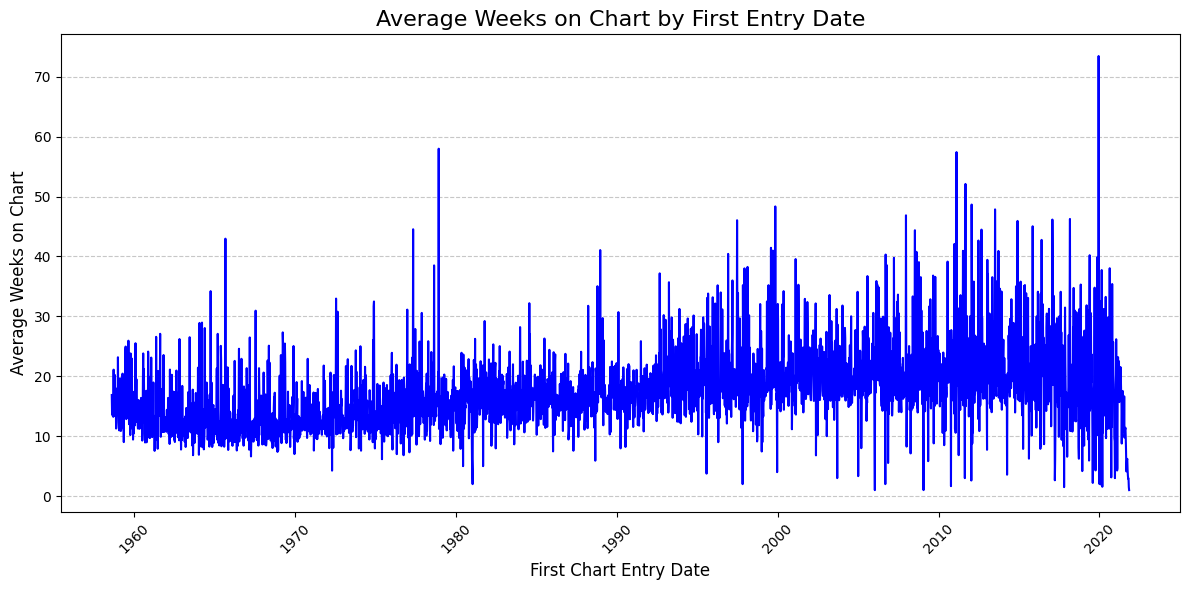

In [6]:
# (1) lineplot_for_avg_weeks
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=average_duration_by_date,
    x='first_entry_date',
    y='average_weeks_on_chart',
    color='blue'
)
plt.title('Average Weeks on Chart by First Entry Date', fontsize=16)
plt.xlabel('First Chart Entry Date', fontsize=12)
plt.ylabel('Average Weeks on Chart', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.savefig("./plots/avg_weeks_lineplot")
plt.tight_layout()
plt.show()

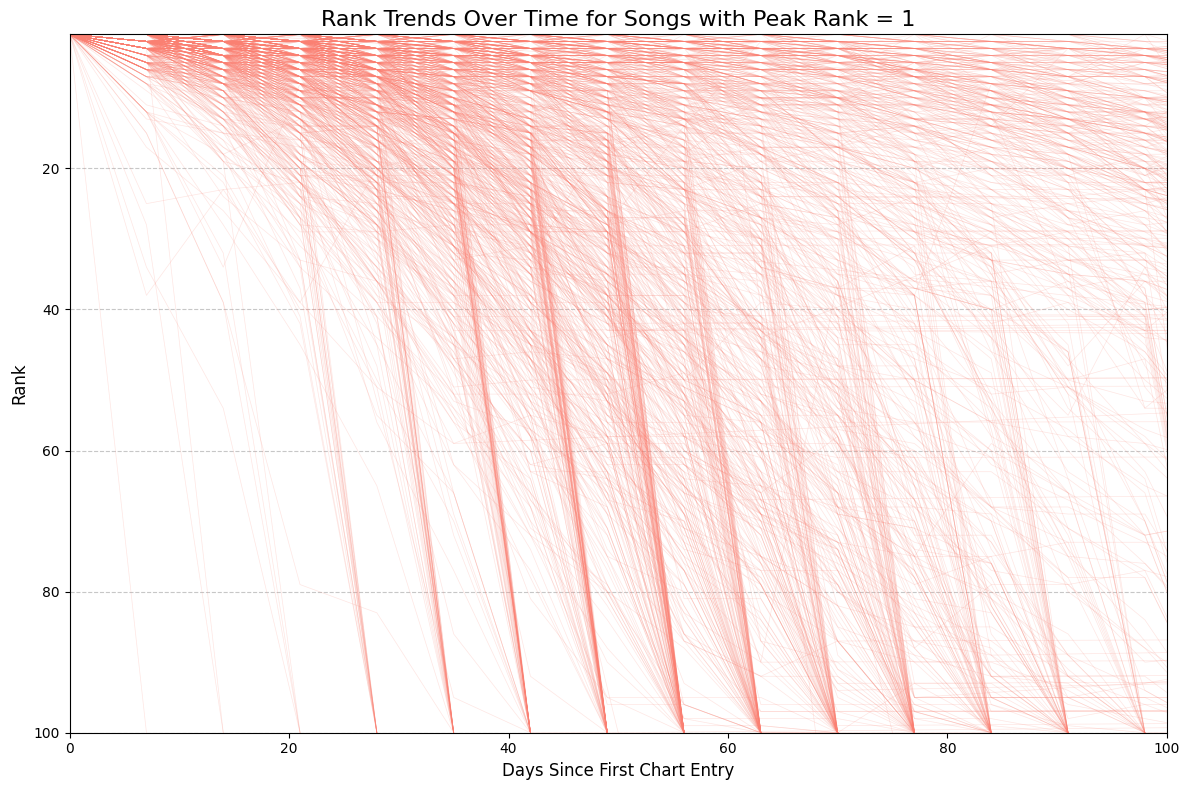

In [7]:
#(2) lineplots_for_rank_change (for peak_rank = 1)
df['date'] = pd.to_datetime(df['date'])  # 날짜 형식 변환
df = df[df['peak_rank'] == 1]  # peak_rank가 1인 곡 필터링
# 각 곡별로 처음 차트인 날짜를 기준으로 흐른 시간 계산
df['days_since_first_entry'] = df.groupby('song')['date'].transform(lambda x: (x - x.min()).dt.days)

def adjust_last_rank(group):
    group = group.sort_values(by='days_since_first_entry')
    group.loc[group.index[-1], 'rank'] = 100  # 마지막 rank 값을 100으로 설정
    return group

df_adjusted = df.groupby('song').apply(adjust_last_rank).reset_index(drop=True)
plt.figure(figsize=(12, 8))

for song, group in df_adjusted.groupby('song'):
    plt.plot(
        group['days_since_first_entry'],
        group['rank'],
        alpha=0.2,
        linewidth=0.5,
        label=None,
        color='salmon'
    )

plt.title('Rank Trends Over Time for Songs with Peak Rank = 1', fontsize=16)
plt.xlabel('Days Since First Chart Entry', fontsize=12)
plt.ylabel('Rank', fontsize=12)
plt.xlim(0,100)
plt.ylim(1,100)
plt.gca().invert_yaxis()  # 순위는 낮을수록 좋으므로 Y축 반전
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("./plots/top1_ranktrend_line_limit_x")
plt.tight_layout()
plt.show()